## Importing libraries

In [1]:
# General data science libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from skimage import io, data, filters
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D, BatchNormalization, GlobalAvgPool2D
from keras.utils.vis_utils import plot_model

## Check GPU

In [2]:
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Number of GPUs available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10891469659293847046
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2249614951
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7336713055147186252
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Data loading

In [3]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

## Data visualization

In [4]:
train_images = train.iloc[:,1:].values.reshape(-1,28,28,1)

In [5]:
def randomDigits():
    # This function plots 25 radom integers from the train dataset
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i, axi in enumerate(ax.flat):
        index = np.random.randint(0, train_images.shape[0])
        axi.imshow(train_images[index].reshape(28, 28), cmap='gray', interpolation='nearest')
        axi.set(xticks=[], yticks=[],
                xlabel=str(train.iloc[index, 0]))

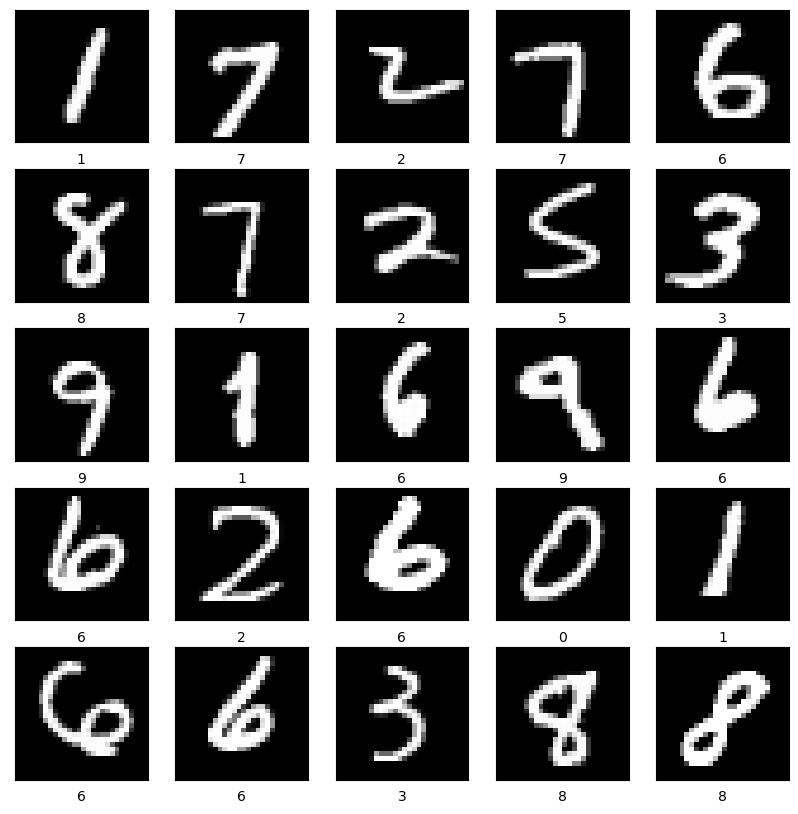

In [6]:
randomDigits()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train['label'], test_size=0.1, random_state=0) #0.2

In [8]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (37800, 28, 28, 1)
X_val shape:  (4200, 28, 28, 1)
y_train shape:  (37800,)
y_val shape:  (4200,)


In [9]:
def plotDistribution(data, title, labels):
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(10), data, color=plt.cm.tab10(np.arange(10)))
    plt.xlabel('Digits')
    plt.ylabel('Count')
    plt.xticks(np.arange(10), labels)
    plt.title(title)
    plt.show()

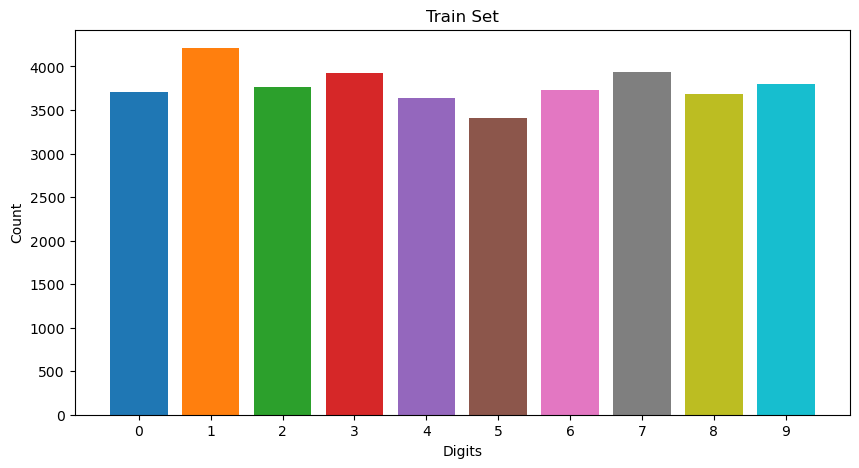

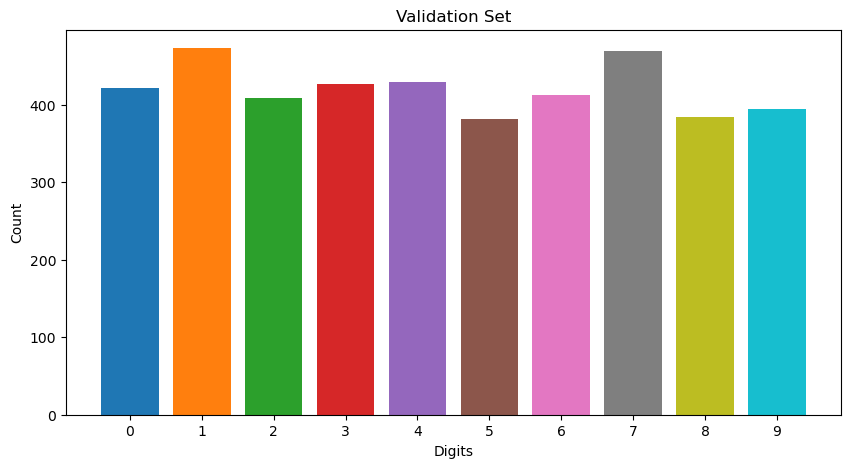

In [10]:
plotDistribution(y_train.value_counts().sort_index(), 'Train Set', y_train.value_counts().sort_index().index)
plotDistribution(y_val.value_counts().sort_index(), 'Validation Set', y_val.value_counts().sort_index().index)

## Modeling

### Model 1

In [11]:
# Using the device name of the GPU
with tf.device ('/device:GPU:0'):
    
    model_1 = tf.keras.models.Sequential([
        
      Input(shape=(28, 28, 1)),
      Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      GlobalAvgPool2D(),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(10, activation='softmax')])

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0

In [13]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# First model, without data augmentation
with tf.device ('/device:GPU:0'):
    history_1 = model_1.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=30, batch_size=16, validation_data=(X_val, tf.keras.utils.to_categorical(y_val)), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.005, verbose=1)])

Epoch 1/30
2363/2363 [==============================] - 26s 8ms/step - loss: 0.2524 - accuracy: 0.9253 - val_loss: 0.1059 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 2/30
2363/2363 [==============================] - 19s 8ms/step - loss: 0.0879 - accuracy: 0.9728 - val_loss: 0.1164 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 3/30
2363/2363 [==============================] - 20s 9ms/step - loss: 0.0667 - accuracy: 0.9788 - val_loss: 0.0928 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 4/30
2363/2363 [==============================] - 20s 8ms/step - loss: 0.0545 - accuracy: 0.9830 - val_loss: 0.0515 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 5/30
2363/2363 [==============================] - 19s 8ms/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 0.0549 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 6/30
2363/2363 [==============================] - 20s 8ms/step - loss: 0.0398 - accuracy: 0.9867 - val_loss: 0.0511 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 7/30
2360/2363 [============================>.

In [15]:
def plotLossAndAccuracy(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()

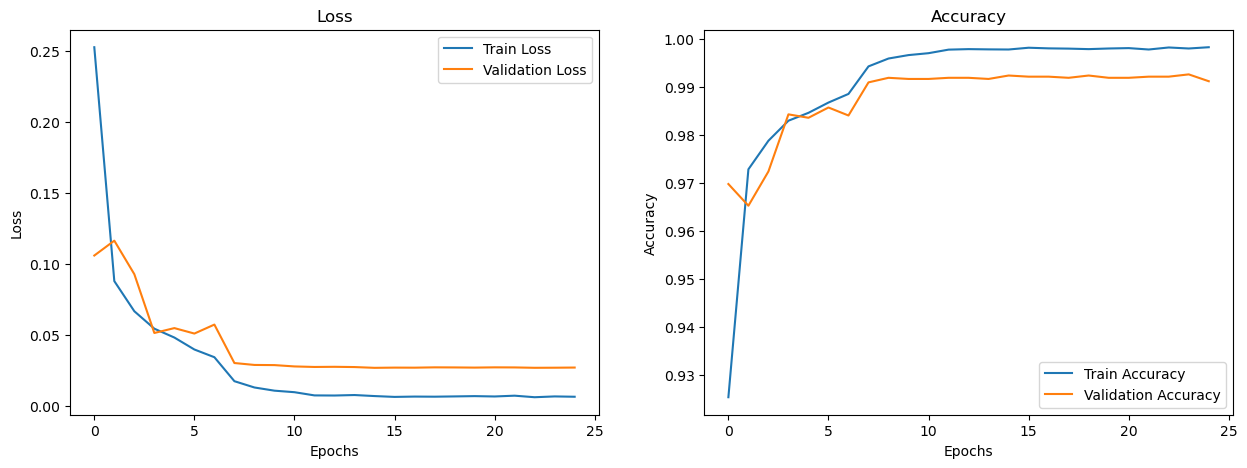

In [16]:
plotLossAndAccuracy(history_1)

132/132 [==============================] - 1s 4ms/step


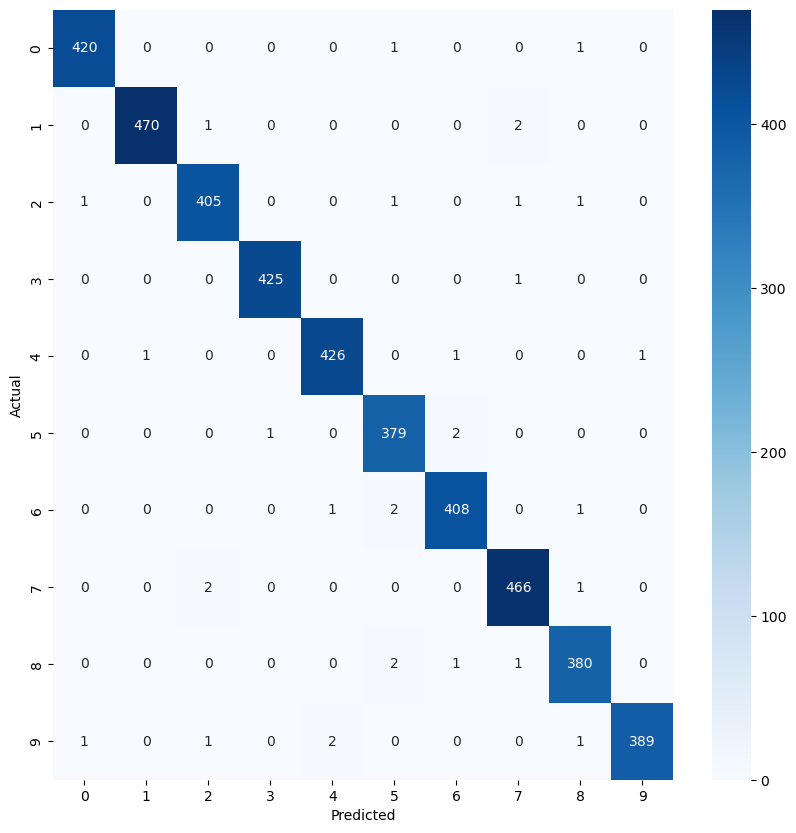

In [17]:
cm = tf.math.confusion_matrix(y_val, np.argmax(model_1.predict(X_val), axis=1))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
print('Accuracy: ', accuracy_score(y_val, np.argmax(model_1.predict(X_val), axis=1)))
print('Precision: ', precision_score(y_val, np.argmax(model_1.predict(X_val), axis=1), average='macro'))
print('Recall: ', recall_score(y_val, np.argmax(model_1.predict(X_val), axis=1), average='macro'))
print('F1 Score: ', f1_score(y_val, np.argmax(model_1.predict(X_val), axis=1), average='macro'))

132/132 [==============================] - 1s 5ms/step
Accuracy:  0.9923809523809524
132/132 [==============================] - 0s 3ms/step
Precision:  0.9922557165070689
132/132 [==============================] - 0s 3ms/step
Recall:  0.9922732041370699
132/132 [==============================] - 1s 4ms/step
F1 Score:  0.992259302231495


### Model 2

In [19]:
# Using the device name of the GPU
with tf.device ('/device:GPU:0'):
    
    model_2 = tf.keras.models.Sequential([
        
      Input(shape=(28, 28, 1)),
      Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      GlobalAvgPool2D(),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(10, activation='softmax')])

In [20]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)       

In [21]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# For data augmentation I prepare the generator of new images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [23]:
# Second model, with data augmentation and 16 batch size
with tf.device ('/device:GPU:0'):
    history_2 = model_2.fit(datagen.flow(X_train, tf.keras.utils.to_categorical(y_train), batch_size=16), epochs=30, validation_data=(X_val, tf.keras.utils.to_categorical(y_val)), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.005, verbose=1)])

Epoch 1/30
2363/2363 [==============================] - 25s 10ms/step - loss: 0.3101 - accuracy: 0.9027 - val_loss: 0.2039 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 2/30
2363/2363 [==============================] - 21s 9ms/step - loss: 0.1160 - accuracy: 0.9644 - val_loss: 0.0765 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/30
2363/2363 [==============================] - 27s 11ms/step - loss: 0.0870 - accuracy: 0.9723 - val_loss: 0.0735 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 4/30
2363/2363 [==============================] - 22s 9ms/step - loss: 0.0764 - accuracy: 0.9765 - val_loss: 0.0668 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 5/30
2363/2363 [==============================] - 24s 10ms/step - loss: 0.0647 - accuracy: 0.9805 - val_loss: 0.0693 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 6/30
2363/2363 [==============================] - 21s 9ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.1237 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 7/30
2362/2363 [===========================

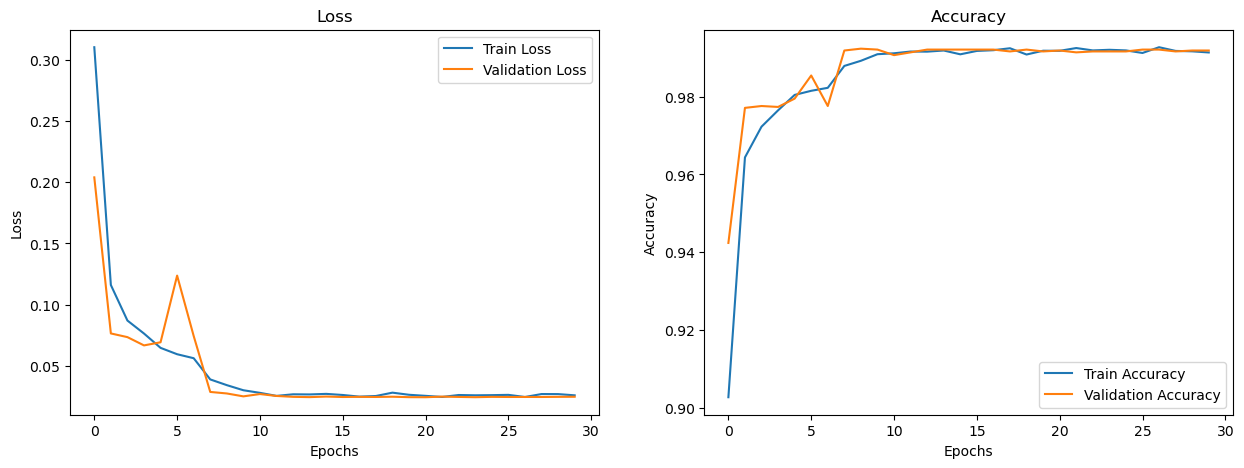

In [24]:
plotLossAndAccuracy(history_2)

132/132 [==============================] - 1s 6ms/step


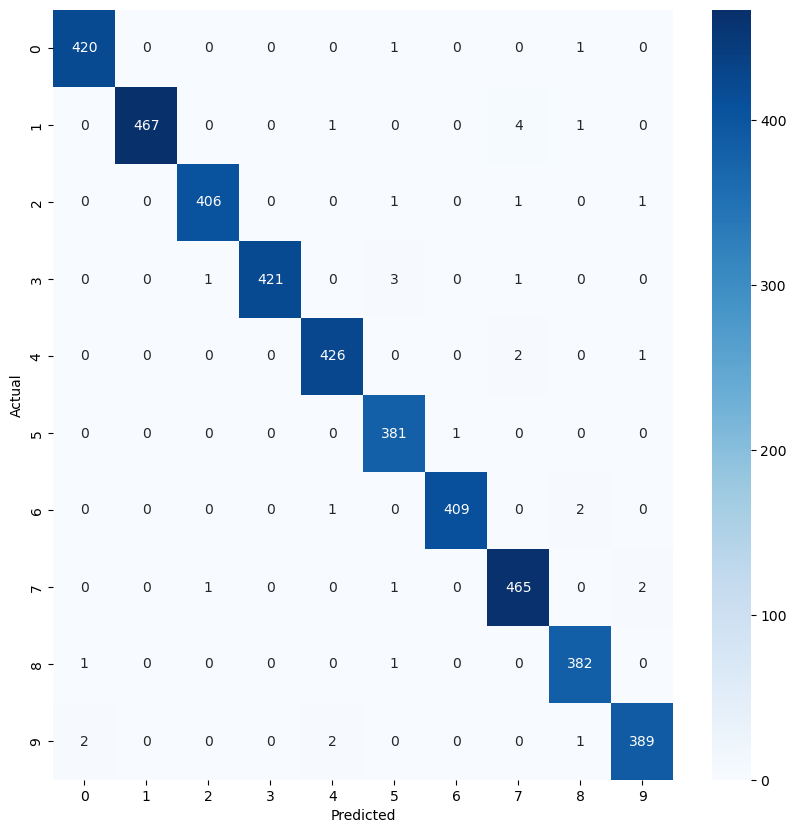

In [25]:
cm = tf.math.confusion_matrix(y_val, np.argmax(model_2.predict(X_val), axis=1))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
print('Accuracy: ', accuracy_score(y_val, np.argmax(model_2.predict(X_val), axis=1)))
print('Precision: ', precision_score(y_val, np.argmax(model_2.predict(X_val), axis=1), average='macro'))
print('Recall: ', recall_score(y_val, np.argmax(model_2.predict(X_val), axis=1), average='macro'))
print('F1 Score: ', f1_score(y_val, np.argmax(model_2.predict(X_val), axis=1), average='macro'))

132/132 [==============================] - 1s 5ms/step
Accuracy:  0.991904761904762
132/132 [==============================] - 1s 8ms/step
Precision:  0.9918211920621012
132/132 [==============================] - 1s 4ms/step
Recall:  0.9920183786801215
132/132 [==============================] - 1s 6ms/step
F1 Score:  0.991901811802977


### Model 3

In [27]:
# Using the device name of the GPU
with tf.device ('/device:GPU:0'):
    
    model_3 = tf.keras.models.Sequential([
        
      Input(shape=(28, 28, 1)),
      Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
      MaxPool2D(),
      BatchNormalization(),

      GlobalAvgPool2D(),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(10, activation='softmax')])

In [28]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

In [29]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# For data augmentation I prepare the generator of new images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [31]:
# Third model, with data augmentation and 32 batch size
with tf.device ('/device:GPU:0'):
    history_3 = model_3.fit(datagen.flow(X_train, tf.keras.utils.to_categorical(y_train), batch_size=32), epochs=30, validation_data=(X_val, tf.keras.utils.to_categorical(y_val)), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.005, verbose=1)])

Epoch 1/30
1182/1182 [==============================] - 37s 30ms/step - loss: 0.3383 - accuracy: 0.8957 - val_loss: 0.1455 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 2/30
1182/1182 [==============================] - 22s 18ms/step - loss: 0.0927 - accuracy: 0.9716 - val_loss: 0.1000 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/30
1182/1182 [==============================] - 38s 32ms/step - loss: 0.0733 - accuracy: 0.9769 - val_loss: 0.1111 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 4/30
1182/1182 [==============================] - 31s 26ms/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.0650 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 5/30
1182/1182 [==============================] - 21s 17ms/step - loss: 0.0559 - accuracy: 0.9829 - val_loss: 0.0480 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/30
1182/1182 [==============================] - 23s 19ms/step - loss: 0.0518 - accuracy: 0.9844 - val_loss: 0.0762 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 7/30
1182/1182 [========================

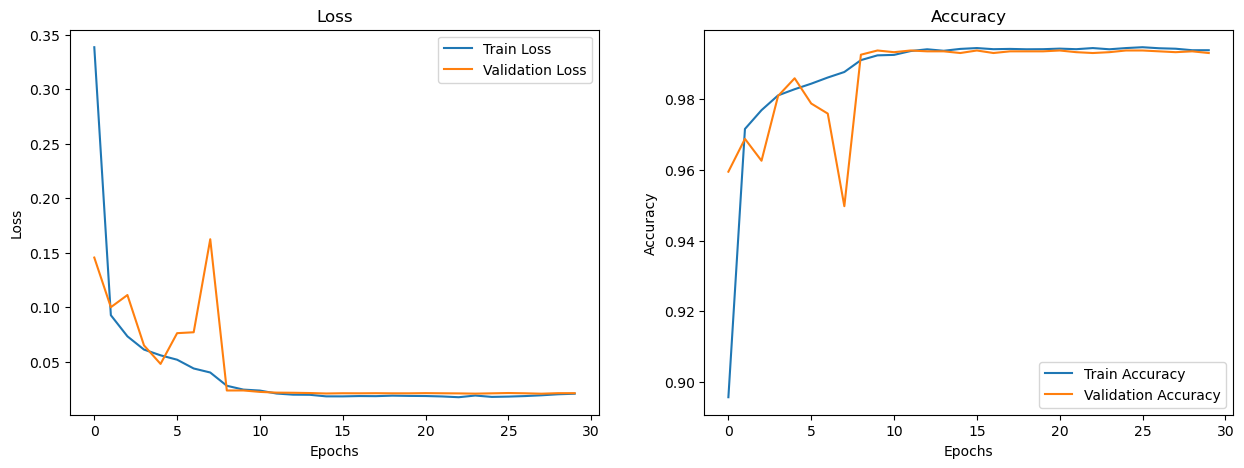

In [32]:
plotLossAndAccuracy(history_3)

132/132 [==============================] - 2s 10ms/step


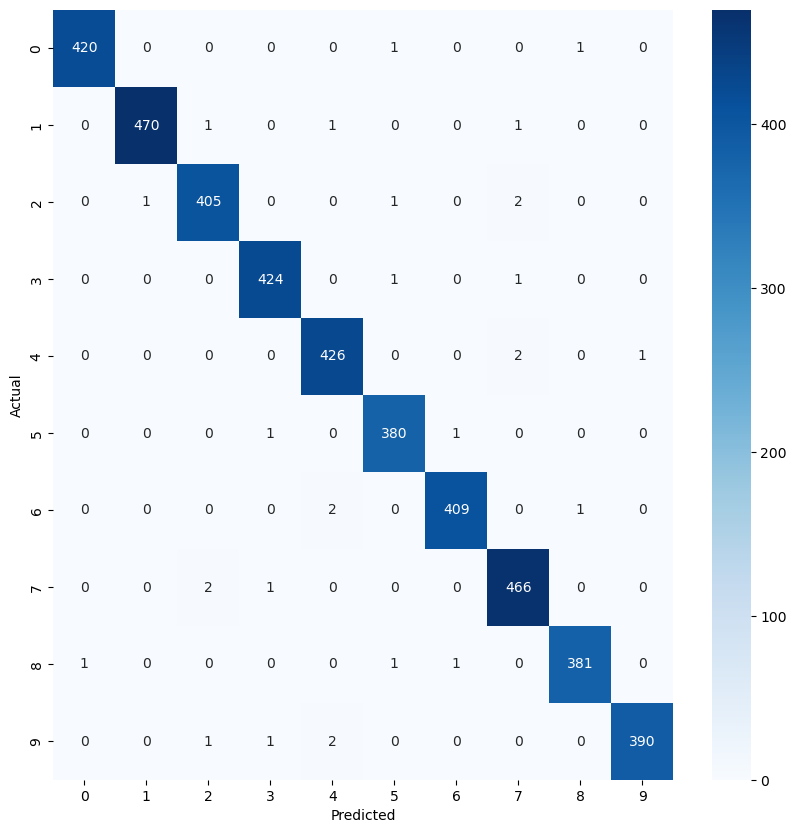

In [33]:
cm = tf.math.confusion_matrix(y_val, np.argmax(model_3.predict(X_val), axis=1))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
print('Accuracy: ', accuracy_score(y_val, np.argmax(model_3.predict(X_val), axis=1)))
print('Precision: ', precision_score(y_val, np.argmax(model_3.predict(X_val), axis=1), average='macro'))
print('Recall: ', recall_score(y_val, np.argmax(model_3.predict(X_val), axis=1), average='macro'))
print('F1 Score: ', f1_score(y_val, np.argmax(model_3.predict(X_val), axis=1), average='macro'))

132/132 [==============================] - 1s 10ms/step
Accuracy:  0.9930952380952381
132/132 [==============================] - 1s 9ms/step
Precision:  0.993132073254472
132/132 [==============================] - 1s 5ms/step
Recall:  0.9930571846776118
132/132 [==============================] - 1s 6ms/step
F1 Score:  0.99308991944125


## Predictions

In [41]:
test_images = test.values.reshape(-1, 28, 28, 1)

In [42]:
predictions_1 = np.argmax(model_1.predict(test_images), axis=1)
predictions_2 = np.argmax(model_2.predict(test_images), axis=1)
predictions_3 = np.argmax(model_3.predict(test_images), axis=1)

875/875 [==============================] - 4s 4ms/step


In [43]:
def randomDigitsTest():
    fig, ax = plt.subplots(5, 5, figsize=(15, 15))
    for index, axi in enumerate(ax.flat):
        axi.imshow(test_images[index].reshape(28, 28), cmap='gray', interpolation='nearest')
        axi.set(xticks=[], yticks=[],
                    xlabel=str(predictions_3[index]))
    plt.show()

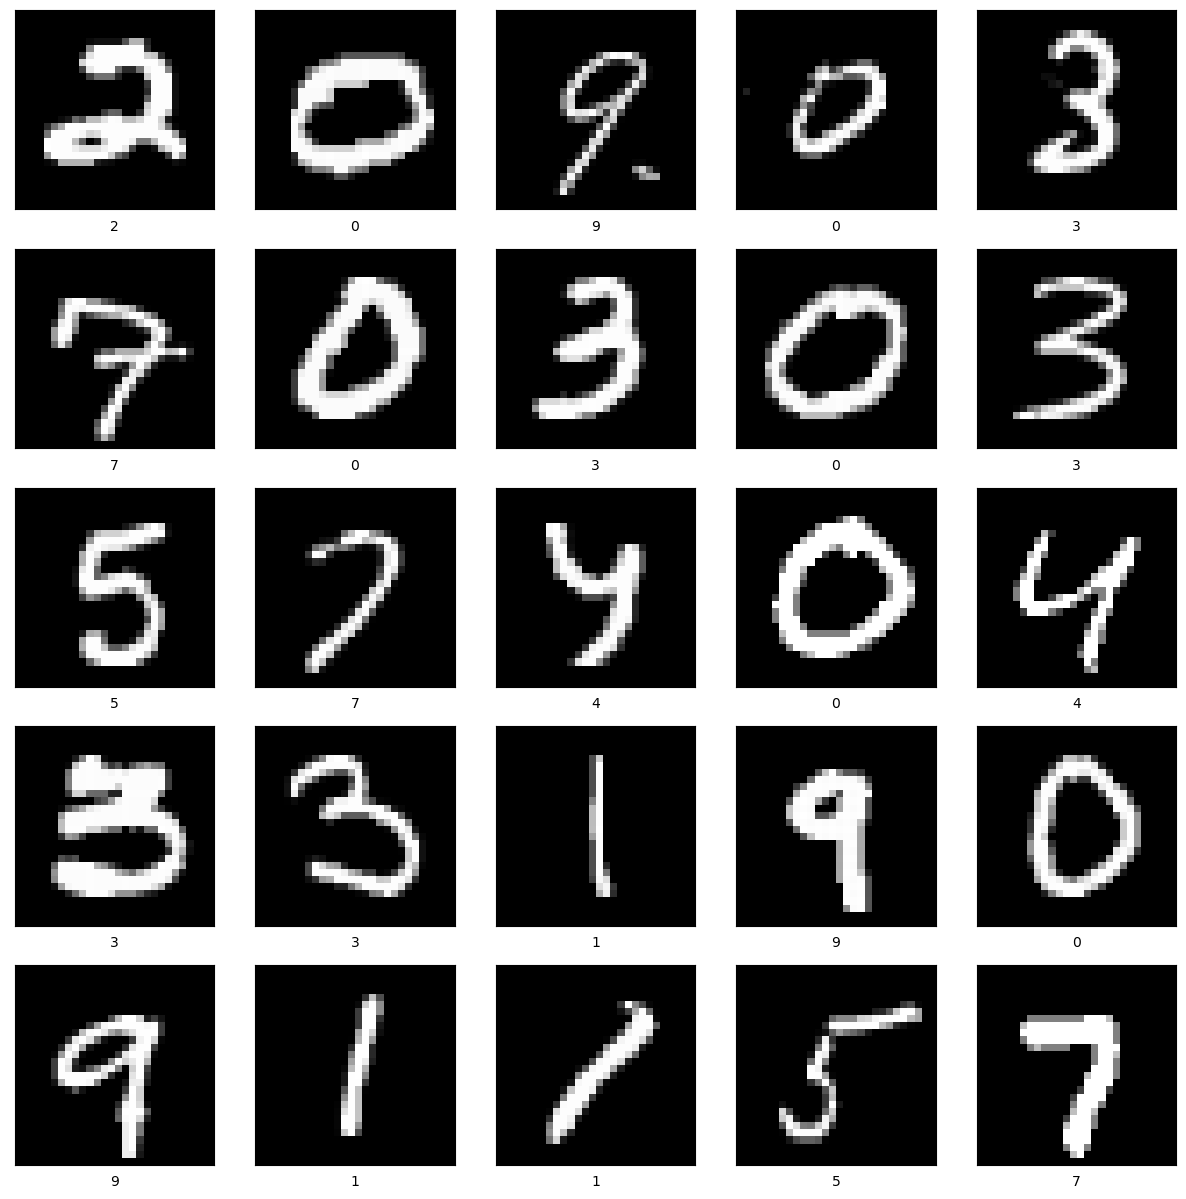

In [44]:
randomDigitsTest()

In [45]:
submission_1 = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predictions_1})
submission_1.to_csv('submission_davide_1.csv', index=False)

submission_2 = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predictions_2})
submission_2.to_csv('submission_davide_2.csv', index=False)

submission_3 = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predictions_3})
submission_3.to_csv('submission_davide_3.csv', index=False)